In [2]:
!pip install stardist csbdeep scikit-image matplotlib

  Using cached scikit_image-0.21.0-cp38-cp38-win_amd64.whl.metadata (14 kB)
  Using cached matplotlib-3.7.5-cp38-cp38-win_amd64.whl.metadata (5.8 kB)
  Using cached imageio-2.35.1-py3-none-any.whl.metadata (4.9 kB)
  Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl.metadata (5.6 kB)
  Using cached scipy-1.10.1-cp38-cp38-win_amd64.whl.metadata (58 kB)
  Using cached tifffile-2023.7.10-py3-none-any.whl.metadata (31 kB)
  Using cached networkx-3.1-py3-none-any.whl.metadata (5.3 kB)
  Using cached pillow-10.4.0-cp38-cp38-win_amd64.whl.metadata (9.3 kB)
  Using cached PyWavelets-1.4.1-cp38-cp38-win_amd64.whl.metadata (1.9 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached contourpy-1.1.1-cp38-cp38-win_amd64.whl.metadata (5.9 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp38-cp38-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.4-py3-none-any.whl.metadata (5.1 kB)
  Using cached importlib_re

In [4]:
!pip install tensorflow

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.11.0-cp38-cp38-win_amd64.whl.metadata (2.5 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.2.3-py3-none-any.whl.metadata (6.5 kB)
  Using cached MarkupSafe-2.1.5-cp38-cp38-win_amd64.whl.metadata (3.1 kB)
   ---------------------------------------- 0.0/276.5 MB ? eta -:--:--
   -----------------

  You can safely remove it manually.


Python 버전: 3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]
NumPy 버전: 1.24.4
StarDist 버전: 0.9.1


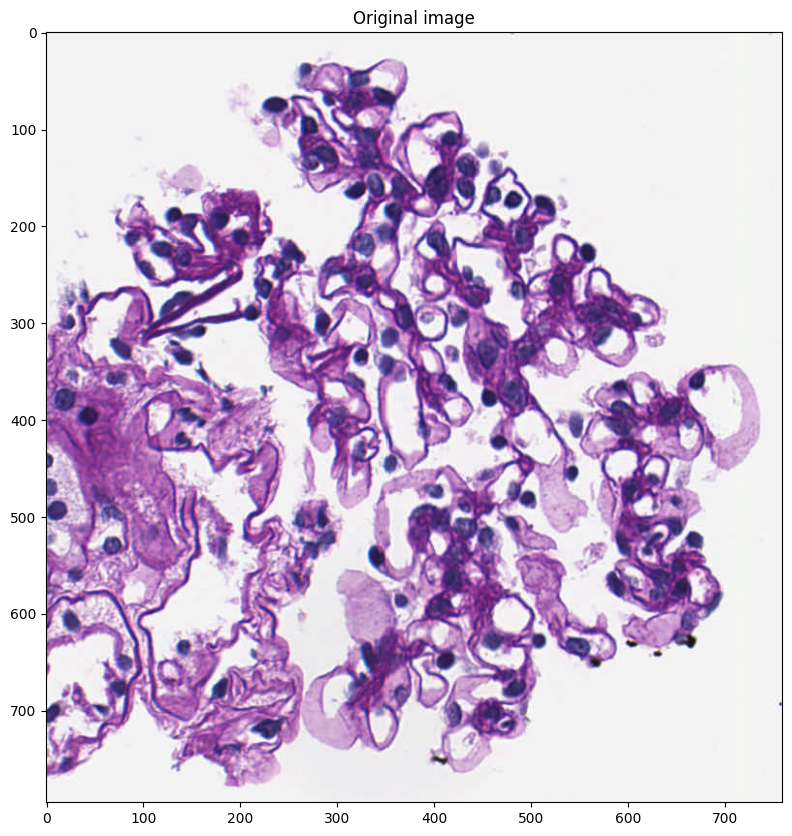

StarDist 모델 로딩 중...
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
세포핵 세그멘테이션 수행 중...


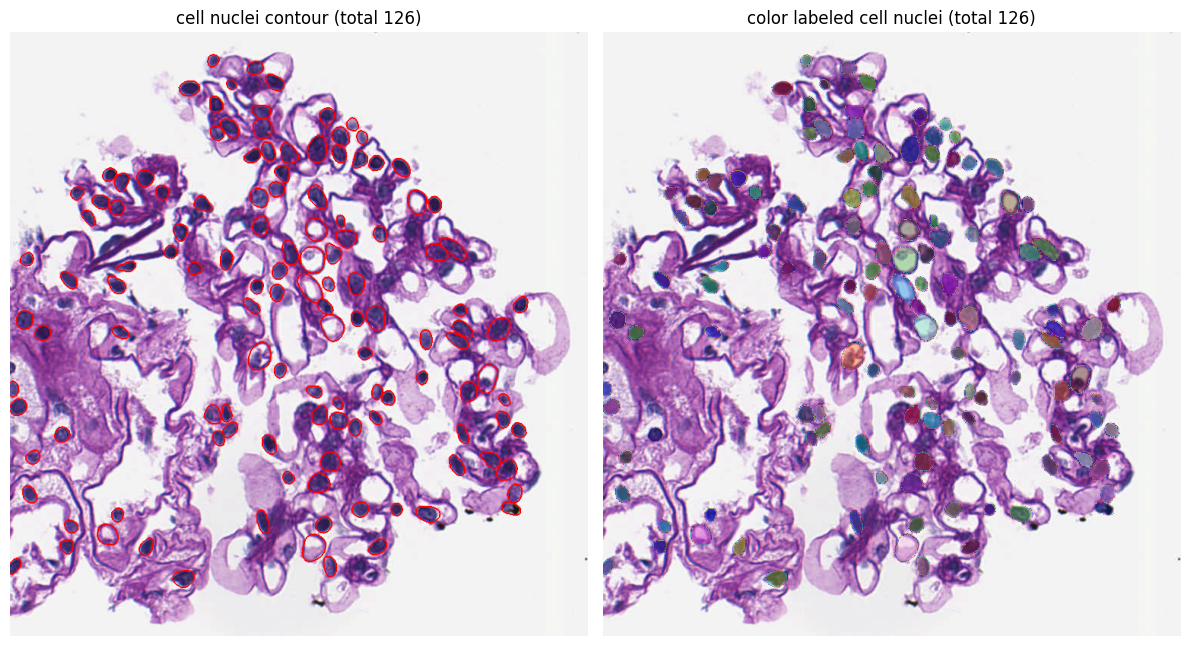

검출된 세포핵 수: 126


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from stardist.models import StarDist2D
from stardist.plot import render_label
from csbdeep.utils import normalize

# Python 및 패키지 버전 확인
import sys
print(f"Python 버전: {sys.version}")
print(f"NumPy 버전: {np.__version__}")
try:
    import stardist
    print(f"StarDist 버전: {stardist.__version__}")
except:
    print("StarDist 버전 정보를 가져올 수 없습니다.")

# 왼쪽 파일 탐색기에 보이는 이미지 파일 중 하나 선택
image_path = "m011_01_0002_PAS_g00.tiff"  # 파일명을 적절히 수정하세요

# 이미지 로드
img = io.imread(image_path)

# 이미지 형식 확인 및 조정
if len(img.shape) == 2:  # 그레이스케일 이미지인 경우
    img = np.stack((img,)*3, axis=-1)
elif len(img.shape) == 3 and img.shape[2] == 4:  # RGBA 이미지인 경우
    img = img[..., :3]

# 원본 이미지 출력
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title('Original image')
plt.show()

# StarDist 모델 로드
print("StarDist 모델 로딩 중...")
model = StarDist2D.from_pretrained('2D_versatile_he')

# 이미지 정규화
img_norm = normalize(img, 1, 99.8)

# 세포핵 예측
print("세포핵 세그멘테이션 수행 중...")
labels, details = model.predict_instances(img_norm)

# 세그멘테이션 결과 시각화 개선
plt.figure(figsize=(12, 12))

# 방법 1: 원본 이미지 위에 경계선만 표시
from skimage.segmentation import find_boundaries
boundaries = find_boundaries(labels, mode='thick')
img_with_boundaries = img.copy()
img_with_boundaries[boundaries] = [255, 0, 0]  # 빨간색 경계선
plt.subplot(1, 2, 1)
plt.imshow(img_with_boundaries)
plt.title(f'cell nuclei contour (total {np.max(labels)})')
plt.axis('off')

# 방법 2: 각 세포핵을 다른 색상으로 표시, 투명도 조정
from matplotlib.colors import ListedColormap
import random
n_labels = np.max(labels)
random_colors = [(random.random(), random.random(), random.random(), 0.7) for _ in range(n_labels + 1)]
random_colors[0] = (0, 0, 0, 0)  # 배경은 투명하게
random_cmap = ListedColormap(random_colors)

plt.subplot(1, 2, 2)
plt.imshow(img)
plt.imshow(labels, cmap=random_cmap, alpha=0.6)
plt.title(f'color labeled cell nuclei (total {np.max(labels)})')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"검출된 세포핵 수: {np.max(labels)}")

StarDist 모델 로딩 중...
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
총 20개의 이미지 파일을 찾았습니다.


이미지 처리 중:   5%|▌         | 1/20 [00:04<01:22,  4.33s/it]

m011_01_0002_PAS_g00: 126개 세포핵 검출


이미지 처리 중:  10%|█         | 2/20 [00:07<01:08,  3.83s/it]

m011_01_0002_PAS_g01: 226개 세포핵 검출


이미지 처리 중:  15%|█▌        | 3/20 [00:12<01:11,  4.19s/it]

m011_01_0002_PAS_g02: 155개 세포핵 검출


이미지 처리 중:  20%|██        | 4/20 [00:17<01:09,  4.35s/it]

m011_01_0002_PAS_g05: 150개 세포핵 검출


이미지 처리 중:  25%|██▌       | 5/20 [00:22<01:08,  4.58s/it]

m011_01_0002_PAS_g08: 83개 세포핵 검출


이미지 처리 중:  30%|███       | 6/20 [00:25<00:59,  4.27s/it]

m011_01_0002_PAS_g09: 154개 세포핵 검출


이미지 처리 중:  35%|███▌      | 7/20 [00:29<00:54,  4.15s/it]

m011_01_0002_PAS_g10: 107개 세포핵 검출


이미지 처리 중:  40%|████      | 8/20 [00:35<00:55,  4.63s/it]

m011_01_0002_PAS_g14: 197개 세포핵 검출


이미지 처리 중:  45%|████▌     | 9/20 [00:39<00:48,  4.45s/it]

m011_01_0002_PAS_g15: 188개 세포핵 검출


이미지 처리 중:  50%|█████     | 10/20 [00:40<00:35,  3.60s/it]

m011_01_0002_PAS_g17: 113개 세포핵 검출


이미지 처리 중:  55%|█████▌    | 11/20 [00:45<00:35,  3.99s/it]

m111_01_0002_PAS_g04: 229개 세포핵 검출


이미지 처리 중:  60%|██████    | 12/20 [00:50<00:33,  4.22s/it]

m111_01_0002_PAS_g06: 236개 세포핵 검출


이미지 처리 중:  65%|██████▌   | 13/20 [00:55<00:31,  4.50s/it]

m111_01_0002_PAS_g11: 177개 세포핵 검출


이미지 처리 중:  70%|███████   | 14/20 [01:00<00:27,  4.54s/it]

m111_01_0002_PAS_g12: 152개 세포핵 검출


이미지 처리 중:  75%|███████▌  | 15/20 [01:04<00:22,  4.52s/it]

m111_01_0002_PAS_g13: 140개 세포핵 검출


이미지 처리 중:  80%|████████  | 16/20 [01:09<00:18,  4.52s/it]

m111_01_0002_PAS_g16: 193개 세포핵 검출


이미지 처리 중:  85%|████████▌ | 17/20 [01:14<00:14,  4.72s/it]

m111_01_0002_PAS_g19: 173개 세포핵 검출


이미지 처리 중:  90%|█████████ | 18/20 [01:20<00:10,  5.10s/it]

m111_01_0002_PAS_g20: 217개 세포핵 검출


이미지 처리 중:  95%|█████████▌| 19/20 [01:23<00:04,  4.55s/it]

m111_01_0002_PAS_g21: 150개 세포핵 검출


이미지 처리 중: 100%|██████████| 20/20 [01:25<00:00,  4.27s/it]

m111_01_0002_PAS_g22: 92개 세포핵 검출

=== 세포핵 검출 결과 요약 ===
m111_01_0002_PAS_g06: 236개 세포핵
m111_01_0002_PAS_g04: 229개 세포핵
m011_01_0002_PAS_g01: 226개 세포핵
m111_01_0002_PAS_g20: 217개 세포핵
m011_01_0002_PAS_g14: 197개 세포핵
m111_01_0002_PAS_g16: 193개 세포핵
m011_01_0002_PAS_g15: 188개 세포핵
m111_01_0002_PAS_g11: 177개 세포핵
m111_01_0002_PAS_g19: 173개 세포핵
m011_01_0002_PAS_g02: 155개 세포핵
m011_01_0002_PAS_g09: 154개 세포핵
m111_01_0002_PAS_g12: 152개 세포핵
m011_01_0002_PAS_g05: 150개 세포핵
m111_01_0002_PAS_g21: 150개 세포핵
m111_01_0002_PAS_g13: 140개 세포핵
m011_01_0002_PAS_g00: 126개 세포핵
m011_01_0002_PAS_g17: 113개 세포핵
m011_01_0002_PAS_g10: 107개 세포핵
m111_01_0002_PAS_g22: 92개 세포핵
m011_01_0002_PAS_g08: 83개 세포핵

총 이미지 수: 20
총 검출 세포핵 수: 3258
이미지당 평균 세포핵 수: 162.90


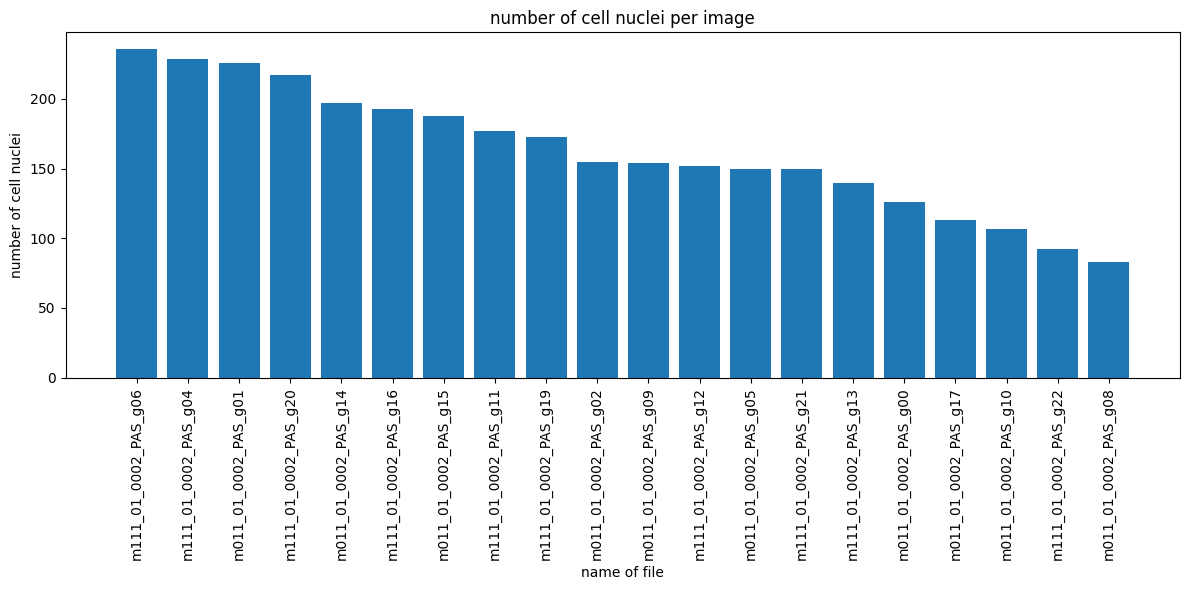

모든 결과가 'segmentation_results' 폴더에 저장되었습니다.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from stardist.models import StarDist2D
from stardist.plot import render_label
from csbdeep.utils import normalize
from skimage.segmentation import find_boundaries
from matplotlib.colors import ListedColormap
import random
import os
import glob
from tqdm import tqdm

# 결과 저장 폴더 생성
results_dir = "segmentation_results"
os.makedirs(results_dir, exist_ok=True)

# StarDist 모델 로드 (한 번만 로드)
print("StarDist 모델 로딩 중...")
model = StarDist2D.from_pretrained('2D_versatile_he')

# 모든 TIFF 파일 찾기
image_files = glob.glob("*.tiff") + glob.glob("*.tif")
print(f"총 {len(image_files)}개의 이미지 파일을 찾았습니다.")

# 이미지 처리 결과를 저장할 딕셔너리
results_data = {}

# 각 이미지 처리
for image_path in tqdm(image_files, desc="이미지 처리 중"):
    # 파일명 추출 (확장자 제외)
    file_basename = os.path.splitext(os.path.basename(image_path))[0]
    
    try:
        # 이미지 로드
        img = io.imread(image_path)
        
        # 이미지 형식 확인 및 조정
        if len(img.shape) == 2:  # 그레이스케일 이미지인 경우
            img = np.stack((img,)*3, axis=-1)
        elif len(img.shape) == 3 and img.shape[2] == 4:  # RGBA 이미지인 경우
            img = img[..., :3]
        
        # 이미지 정규화
        img_norm = normalize(img, 1, 99.8)
        
        # 세포핵 예측
        labels, details = model.predict_instances(img_norm)
        
        # 결과 저장
        num_nuclei = np.max(labels)
        results_data[file_basename] = {
            "num_nuclei": num_nuclei,
            "labels": labels,
            "details": details
        }
        
        # 시각화 - 두 가지 방식으로
        plt.figure(figsize=(16, 8))
        
        # 1. 경계선 표시
        boundaries = find_boundaries(labels, mode='thick')
        img_with_boundaries = img.copy()
        img_with_boundaries[boundaries] = [255, 0, 0]  # 빨간색 경계선
        
        plt.subplot(1, 2, 1)
        plt.imshow(img_with_boundaries)
        plt.title(f'cell nuclei contour (total {num_nuclei})')
        plt.axis('off')
        
        # 2. 색상 라벨링
        n_labels = np.max(labels)
        random_colors = [(random.random(), random.random(), random.random(), 0.7) for _ in range(n_labels + 1)]
        random_colors[0] = (0, 0, 0, 0)  # 배경은 투명하게
        random_cmap = ListedColormap(random_colors)
        
        plt.subplot(1, 2, 2)
        plt.imshow(img)
        plt.imshow(labels, cmap=random_cmap, alpha=0.6)
        plt.title(f'color labelled cell nuclei (total {num_nuclei})')
        plt.axis('off')
        
        # 결과 저장
        plt.suptitle(f"file: {file_basename}", fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f"{file_basename}_segmentation.png"), dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"{file_basename}: {num_nuclei}개 세포핵 검출")
        
    except Exception as e:
        print(f"{file_basename} 처리 중 오류 발생: {e}")

# 모든 이미지의 세포핵 수 요약
print("\n=== 세포핵 검출 결과 요약 ===")
total_nuclei = 0
results_summary = []

for filename, data in results_data.items():
    num_nuclei = data["num_nuclei"]
    total_nuclei += num_nuclei
    results_summary.append((filename, num_nuclei))

# 세포핵 수에 따라 정렬
results_summary.sort(key=lambda x: x[1], reverse=True)

# 결과 출력
for filename, count in results_summary:
    print(f"{filename}: {count}개 세포핵")

print(f"\n총 이미지 수: {len(results_data)}")
print(f"총 검출 세포핵 수: {total_nuclei}")
print(f"이미지당 평균 세포핵 수: {total_nuclei/len(results_data) if results_data else 0:.2f}")

# 히스토그램으로 시각화
plt.figure(figsize=(12, 6))
counts = [count for _, count in results_summary]
filenames = [filename for filename, _ in results_summary]
plt.bar(filenames, counts)
plt.xticks(rotation=90)
plt.title('number of cell nuclei per image')
plt.ylabel('number of cell nuclei')
plt.xlabel('name of file')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "nuclei_count_summary.png"), dpi=300, bbox_inches='tight')
plt.show()

print(f"모든 결과가 '{results_dir}' 폴더에 저장되었습니다.")